In [ ]:
!pip install opencv-python
!pip list | grep 'opencv'

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path


In [4]:
import ipyplot

all_images = list(Path("./biodiversity_library/72157719532261290/").rglob("*.jpg"))
ipyplot.plot_images([str(e) for e in all_images], max_images=20, img_width=200)


## 1. Naive CV2 thresholding
- Patchy outputs > too much fiddliness with thresholding for per image

In [ ]:
def remove_background_white(img_path):
    # via https://stackoverflow.com/questions/64491530/how-to-remove-the-background-from-a-picture-in-opencv-python
    img = cv2.imread(str(img_path))
    lower_thresh = 190
    lower = np.array([lower_thresh, lower_thresh, lower_thresh])
    upper = np.array([255, 255, 255])

    # select everything within thresh (colours idealy)
    thresh = cv2.inRange(img, lower, upper)

    # apply morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # invert morp image
    mask = 255 - morph

    # apply mask to image
    result = cv2.bitwise_and(img, img, mask=mask)

    return thresh


ipyplot.plot_images([str(e) for e in all_images], max_images=20, img_width=150)
ipyplot.plot_images(
    [remove_background_white(e) for e in all_images], max_images=20, img_width=150
)


## 2. Skimage filtering algorithms
- https://scikit-image.org/docs/stable/auto_examples/
- helpful crash course notes: https://scikit-image.org/docs/stable/user_guide/numpy_images.html
- transparent mask: https://stackoverflow.com/questions/62813546/how-do-i-crop-an-image-based-on-custom-mask-in-python
- morphological transformations: https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
- masks are pretty good? but still contain noise/partial masking of subjects
- create contours > per subject image extraction > lots of contours aren't closed; issues with filling in the contours

In [ ]:
# find a decent filter
from skimage.filters import try_all_threshold

for image in all_images:
    image = cv2.imread(str(image))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    fig, ax = try_all_threshold(gray, figsize=(12, 12), verbose=False)
    plt.show()


In [ ]:
# find largest things in image > proportion of image size > split into individual masks > save individuals
# fill inside largest outline?
# find all contours > thresh?

# try and remove small objects? https://www.kite.com/blog/python/image-segmentation-tutorial/
from skimage.morphology import remove_small_objects

ipyplot.plot_images([mask, remove_small_objects(mask)], max_images=20, img_width=400)


In [5]:
import shutil

from skimage.filters import (
    threshold_mean,
    threshold_otsu,
    threshold_triangle,
    threshold_yen,
)

ipyplot_img_with = 500


def get_threshold_triangle_mask(cv2_image, log=True):
    # creat image mask
    gray = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY)
    mask = gray > threshold_triangle(gray)  # yen, triangle or mean?
    gray[mask] = 0

    if log:
        ipyplot.plot_images(
            [mask.astype(np.uint8), gray], max_images=20, img_width=ipyplot_img_with
        )
    return gray, mask


def apply_mask(image, mask, save_dir, image_name, log=True):
    # apply mask
    mask_2 = mask.astype(np.uint8)
    mask_2 = (~mask_2.astype(bool)).astype(np.uint8)

    # smooth morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    mask_2 = cv2.morphologyEx(mask_2, cv2.MORPH_OPEN, kernel)

    # apply mask
    masked = cv2.bitwise_and(image, image, mask=mask_2)
    if log:
        ipyplot.plot_images([masked], max_images=20, img_width=ipyplot_img_with)

    if save_dir:
        cv2.imwrite(str(save_dir / f"{image_name}_mask.jpeg"), masked)
    return masked


def remove_background(masked_image, save_dir, image_name, log=True):
    # save with transparent background
    tmp = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(masked_image)
    rgba = [b, g, r, alpha]
    masked_tr = cv2.merge(rgba, 4)

    if log:
        ipyplot.plot_images([masked_tr], max_images=20, img_width=ipyplot_img_with)

    if save_dir:
        cv2.imwrite(str(save_dir / f"{image_name}_mask.png"), masked_tr)

    return masked_tr


save_dir = Path("./temp_output/")
shutil.rmtree(str(save_dir)) if save_dir.exists() else None
save_dir.mkdir()
for image_file in all_images[:3]:
    image = cv2.imread(str(image_file))
    gray, mask = get_threshold_triangle_mask(image, log=False)
    # mask = ndi.binary_fill_holes(mask)
    masked = apply_mask(image, mask, save_dir, image_file.stem, log=False)
    masked_bg_removed = remove_background(masked, save_dir, image_file.stem, log=False)


## Skimage segmentation tutorial
- https://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html?highlight=contour
- focus on using canny edge detection

In [9]:
from scipy import ndimage as ndi
from skimage import data
from skimage.color import rgb2gray
from skimage.exposure import histogram
from skimage.feature import canny
from skimage.segmentation import watershed
from skimage.filters import sobel

plt_figsize = (10, 10)

In [ ]:
# convert to gray
image = cv2.imread(str(all_images[2]))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# gray = rgb2gray(image)
# enhance = cv2.equalizeHist(gray) # probably not; terrible chunking effect

# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # luminescence values?
# gray_sk = rgb2gray(image)
# gray
# gray_sk


In [ ]:
# get edges
input_img = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
edges = canny(input_img / 255.0)
edges_2 = edges.astype(np.uint8)
plt.figure(figsize=plt_figsize)
plt.imshow(edges_2)


In [ ]:
# fill inside of edges - binary fill
fill_edges = ndi.binary_fill_holes(
    edges_2, structure=cv2.getStructuringElement(cv2.MORPH_OPEN, (20, 20))
)
plt.figure(figsize=plt_figsize)
plt.imshow(fill_edges)

# fill with flood?
from skimage.segmentation import flood, flood_fill

flood_fill(edges_2)


In [ ]:
elevation_map = sobel(gray)
plt.figure(figsize=plt_figsize)
plt.imshow(elevation_map)


In [ ]:

markers = np.zeros_like(gray)
markers[gray < 20] = 1
markers[gray > 50] = 2

segmentation = watershed(elevation_map, markers)

plt.figure(figsize=plt_figsize)
plt.imshow(segmentation)


## HED edge detection
- DL based instead? > semantic understanding of image
- https://pyimagesearch.com/2019/03/04/holistically-nested-edge-detection-with-opencv-and-deep-learning/
- https://cv-tricks.com/opencv-dnn/edge-detection-hed/

## Apply low-level segmentation?
- https://scikit-image.org/docs/stable/auto_examples/edges/plot_active_contours.html#sphx-glr-auto-examples-edges-plot-active-contours-py
- Not effective; outlines of sub-segments still spill/chaotic

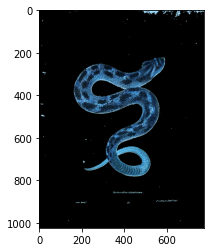

In [13]:
plt.imshow(masked)

In [18]:
segments_fz

array([[ 0,  0,  0, ..., 12, 12, 12],
       [ 0,  0,  0, ..., 12, 12, 12],
       [ 0,  0,  0, ..., 12, 12, 12],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

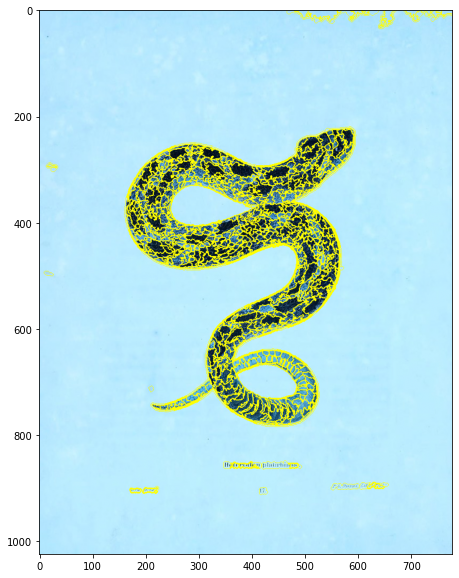

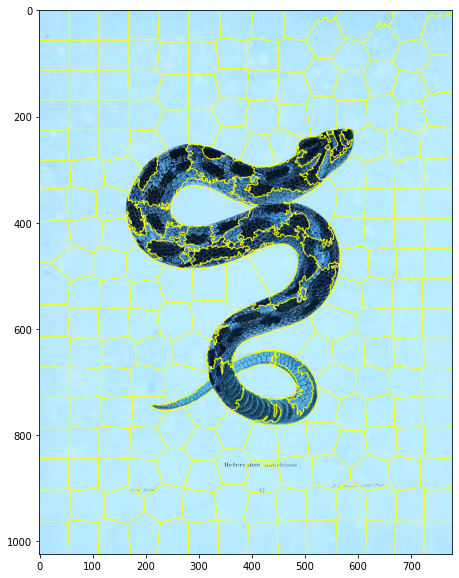

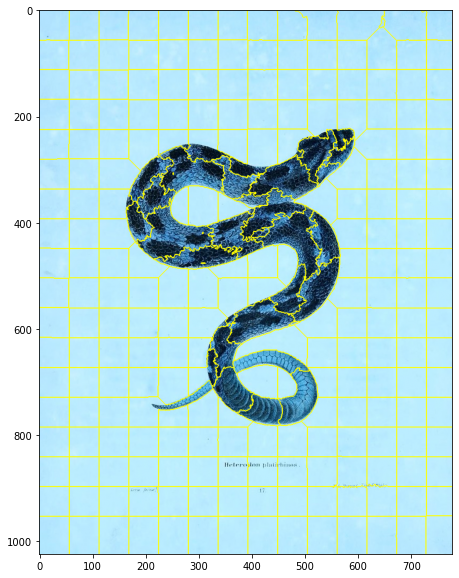

In [15]:
from skimage.segmentation import (
    felzenszwalb,
    mark_boundaries,
    quickshift,
    slic,
    watershed,
)

# image = cv2.imread(str(all_images[2]))

segments_fz = felzenszwalb(masked, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(masked, n_segments=250, compactness=10, sigma=1, start_label=1)
segments_quick = quickshift(masked, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(masked))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

plt.figure(figsize=plt_figsize)
plt.imshow(mark_boundaries(image, segments_fz))

plt.figure(figsize=plt_figsize)
plt.imshow(mark_boundaries(image, segments_slic))

# plt.figure(figsize=plt_figsize)
# plt.imshow(mark_boundaries(image, gradient))

plt.figure(figsize=plt_figsize)
plt.imshow(mark_boundaries(image, segments_watershed))


## Find contours
- https://scikit-image.org/docs/stable/auto_examples/edges/plot_contours.html
- issues with contour selection? often contours the entire image after filtering

In [ ]:
from skimage import measure

# constant value not suitable for inputs
contours = measure.find_contours(gray, 0.8)

# Display the image and plot all contours found
plt.figure(figsize=plt_figsize)
fig, ax = plt.subplots()
ax.imshow(gray, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis("image")
ax.set_xticks([])
ax.set_yticks([])

plt.show()


In [ ]:
# https://stackoverflow.com/questions/67285972/how-to-fill-canny-edge-image-in-opencv-python
contours = cv2.findContours(
    mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
contours = contours[0] if len(contours) == 2 else contours[1]

min_contour_size = 0.1
filtered_contours = [
    e for e in contours if (cv2.contourArea(e) / masked.size) > min_contour_size
]

# large-ish contours are the same size as the image?
gray.size
cv2.contourArea(filtered_contours[0])

# # draw white filled contour on black background
# result = np.zeros_like(gray)
# cv2.drawContours(result, [big_contour], 0, (255,255,255), cv2.FILLED)

# ipyplot.plot_images([gray], max_images=20, img_width=400)


In [ ]:
# https://betterprogramming.pub/image-segmentation-python-7a838a464a84
# temp = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
contours = cv2.findContours(
    mask.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
)[-2]

min_contour_size = 0.1
filtered_contours = [
    e for e in contours if (cv2.contourArea(e) / masked.size) > min_contour_size
]

cv2.drawContours(gray, filtered_contours, -1, (0, 255, 0), 1)
ipyplot.plot_images([gray], max_images=20, img_width=400)
